In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable
import copy
import eofs

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [3]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get data

ExSamples data for the specific ensemble member:

In [10]:
ExS_GBR_lsm_slice = ExS_GBR_lsm.sel(latitude=slice(62,48),longitude=slice(-13,5))

In [11]:
ExS_8960966_psl = xr.open_dataset(ExS_dataloc+'HotWinter2066-r001i1p02868/NAtlanticEurope/psl_daily/HotWinter2066-r001i1p02868_psl_daily_NAtlanticEurope_members0754-0847.nc').sel(ensemble_member_id=8960966).squeeze().rename({'latitude4':'latitude','longitude4':'longitude','time1':'time','item16222_daily_mean':'psl'}).psl/100
ExS_8960966_tx = xr.open_dataset(ExS_dataloc+'HotWinter2066-r001i1p02868/UK/tasmax_daily/HotWinter2066-r001i1p02868_tasmax_daily_UK_members0000-1035.nc').sel(ensemble_member_id=8960966).squeeze().rename({'latitude4':'latitude','longitude4':'longitude','time1':'time','item3236_daily_maximum':'tasmax'}).assign_coords(latitude=ExS_GBR_lsm_slice.latitude,longitude=ExS_GBR_lsm_slice.longitude).tasmax
ExS_8960966_pr = xr.open_dataset(ExS_dataloc+'HotWinter2066-r001i1p02868/UK/pr_daily/HotWinter2066-r001i1p02868_pr_daily_UK_members0000-1032.nc').sel(ensemble_member_id=8960966).squeeze().rename({'latitude2':'latitude','longitude2':'longitude','time1':'time','item5216_6hrly_mean':'pr'}).assign_coords(latitude=ExS_GBR_lsm_slice.latitude,longitude=ExS_GBR_lsm_slice.longitude).pr

## Storyline of the event

In [12]:
ExS_8960966_tx_GBR = ExS_8960966_tx.sel(time=ExS_8960966_tx['time.month'].isin([12,1,2])).where(ExS_GBR_lsm_slice).weighted(np.cos(np.deg2rad(ExS_8960966_tx.latitude))).mean(['longitude','latitude'])

In [13]:
## time-of-max
pd.Series(ExS_8960966_tx_GBR.values,ExS_8960966_tx_GBR.time.values).idxmax()

cftime.Datetime360Day(2066, 2, 28, 12, 0, 0, 0)

In [14]:
## two weeks leading up to max:
time_of_max = '2066-02-28'
period_of_max = slice('2066-02-15','2066-02-28')

## get baseline for anomaly computation

In [15]:
def preproc_baseline(ds):
    ds=ds.squeeze()
    latlon_names = [x for x in ds.coords if ('latitude' in x)|('longitude' in x)|('time' in x)]
    ds=ds.rename(dict(zip(latlon_names,['time','latitude','longitude'])))
    ds = ds.sel(time=(ds['time.month']==2)&(ds['time.day']==28))
    return ds

ExS_2868_pr_base =  xr.open_mfdataset(glob.glob(ExS_dataloc+'/BaselineWinters/UK/pr_daily/*2868*.nc'),preprocess=preproc_baseline).rename(dict(item5216_6hrly_mean='pr')).pr
ExS_2868_psl_base = xr.open_mfdataset(glob.glob(ExS_dataloc+'/BaselineWinters/NAtlanticEurope/psl_daily/*2868*.nc'),preprocess=preproc_baseline).rename(dict(item16222_daily_mean='psl')).psl/100
ExS_2868_tx_base = xr.open_mfdataset(glob.glob(ExS_dataloc+'/BaselineWinters/UK/tasmax_daily/*2868*.nc'),preprocess=preproc_baseline).rename(dict(item3236_daily_maximum='tasmax')).tasmax

''

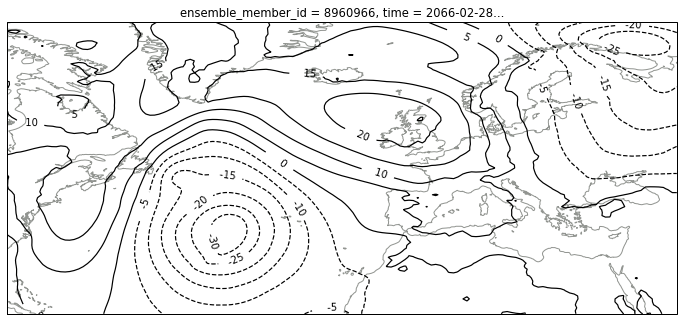

In [16]:
fig,ax = plt.subplots(figsize=(12,6),subplot_kw=dict(projection=crs.PlateCarree()))

p=(ExS_8960966_psl-ExS_2868_psl_base.mean(['ensemble_member_id','time'])).sel(time=time_of_max).squeeze().plot.contour(ax=ax,colors='k',levels=np.linspace(-30,30,13))

p.axes.coastlines('50m',lw=1,color='xkcd:grey')

plt.clabel(p,levels=np.linspace(-30,30,13),fmt=r'%4d')

''

''

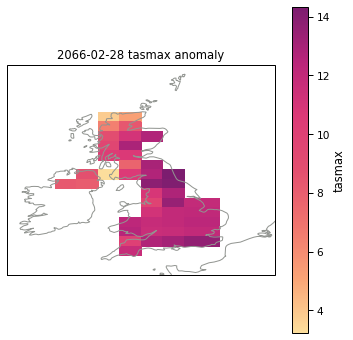

In [17]:
fig,ax = plt.subplots(figsize=(6,6),subplot_kw=dict(projection=crs.PlateCarree()))

p=(ExS_8960966_tx-ExS_2868_tx_base.mean(['ensemble_member_id','time'])).where(ExS_GBR_lsm_slice).sel(time=time_of_max,latitude=slice(61,50),longitude=slice(-10,2.5)).plot(ax=ax,cmap=palettable.cartocolors.sequential.SunsetDark_7.mpl_colormap)

p.axes.coastlines('50m',lw=1,color='xkcd:grey')

plt.title('2066-02-28 tasmax anomaly')

''

### Is this the hottest ExSamples gets?

In [18]:
def preproc_ExS_txx(ds):
    
    ds = ds.rename(dict(item3236_daily_maximum='tasmax',longitude4='longitude',latitude4='latitude',time1='time')).tasmax.squeeze()
    
    ds = ds.sel(time=ds['time.month'].isin([12,1,2]))
    
    ds = ds.max('time')
    
    ds = ds.where(ExS_GBR_lsm_slice).max(['longitude','latitude'])
    
    return ds

ExS_txx_2868 = preproc_ExS_txx(xr.open_dataset(ExS_dataloc+'/HotWinter2066-r001i1p02868/UK/tasmax_daily/HotWinter2066-r001i1p02868_tasmax_daily_UK_members0000-1035.nc'))
ExS_txx_1554 = preproc_ExS_txx(xr.open_dataset(ExS_dataloc+'/HotWinter2072-r001i1p01554/UK/tasmax_daily/HotWinter2072-r001i1p01554_tasmax_daily_UK_members0000-0882.nc'))
ExS_txx_2242 = preproc_ExS_txx(xr.open_dataset(ExS_dataloc+'/WetWinter2068-r001i1p02242/UK/tasmax_daily/WetWinter2068-r001i1p02242_tasmax_daily_UK_members0000-0916.nc'))

In [19]:
print('ensemble member',ExS_txx_2868.to_pandas().idxmax(),'| value',ExS_txx_2868.max().values[()]-273.15)
print('ensemble member',ExS_txx_1554.to_pandas().idxmax(),'| value',ExS_txx_1554.max().values[()]-273.15)
print('ensemble member',ExS_txx_2242.to_pandas().idxmax(),'| value',ExS_txx_2242.max().values[()]-273.15)

ensemble member 8960966 | value 23.385980224609398
ensemble member 8870601 | value 21.076409912109398
ensemble member 8860306 | value 21.398950195312523


#### Answer: YES